# Title

## Introduction

**Heart diseases** are the most common cause of death globally (CDC 2022). One common cause for heart disease is the narrowing of blood vessels that supply blood to or from the heart (CDC 2022).

In this analysis, we will answer the question: **Can we predict a heart disease diagnosis based on age, serum cholesterol, resting blood pressure, maximum heart rate, and exercised-induced ST Depression, using the KNN Classification Algorithm?**, using Janosi and colleage's *Heart Disease* dataset (1988).

The dataset includes data from individuals including patients' information, including the predictors mentioned above such as age and cholesterol. It also mentions their heart disease diagnosis. The diagnosis is categorical, including 0 (indicating absence of heart disease) and 1 (indicating presence of heart disease). Here, the diagnosis for heart disease indicates >50% narrowing in any major blood vessel.

The data provided from four different locations. All four locations' data will be combined and used in this analysis. While some of the data collect uses a scale from 0 to 4 to rank the severity of the heart disease diagnosis, values 1 to 4 all indicate the presence of heart disease. So, this scale can be converted to a 0 to 1 scale.

***
## Preliminary Exploratory Data Analysis

In [7]:
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Reading and Wrangling

In [8]:
# Reading data from web (stored in github repo)
cleveland_url <- "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.cleveland.csv"
hungarian_url <- "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.hungarian.csv"
switzerland_url <- "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.switzerland.csv"
beach_url <-  "https://raw.githubusercontent.com/Dangel02/heartdisease_dataset/845acf4c5845b3583c8b2ec85c7c1ac36cae478d/data/processed.va.csv"

names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thanl", "num")

cleveland <- read_csv(cleveland_url, col_names = names)
hungarian <- read_csv(hungarian_url, col_names = names)
switzerland <- read_csv(switzerland_url, col_names = names)
beach <- read_csv(beach_url, col_names = names)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thanl
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, restecg, thalach, exang, slope, ca, thanl
dbl (5): age, sex, cp, oldpeak, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, fbs, restecg, thalach, exang, oldpeak, slope, ca, thanl
dbl (5): age, sex, cp, chol, num

ℹ Use `spec()` to r

In [ ]:
# Changing all columns to doubles to be able to combine the 4 dataframes

cleveland <- mutate_all(cleveland, as.double)
hungarian <- mutate_all(hungarian, as.double)
switzerland <- mutate_all(switzerland, as.double)
beach <- mutate_all(beach, as.double)

heart_data_combined <- bind_rows(cleveland, hungarian, switzerland, beach)
heart_data_combined

The dataframes are now combined into one dataset, which is already tidy.

As mentioned, the heart disease status data (num) was collected in some locations using a scale from 0-4. All num values from 1 to 4 were changed to 1.

In [6]:
heart_data <- heart_data_combined |>
                mutate(num = ifelse(num %in% 1:4, 1, num)) |> # Correcting scaling of heart disease data (num)
                filter(chol != 0) |> # There is one incorrect point where chol = 0
                mutate(num = as_factor(num))

ERROR: Error in mutate(filter(mutate(heart_data_combined, num = ifelse(num %in% : could not find function "mutate"


In [ ]:
# Remove observations with NA values for predictor variables (age, chol, trestbps, thalach, oldpeak) only
heart_data <- heart_data |>
                filter(!is.na(age), !is.na(chol), !is.na(trestbps), !is.na(thalach), !is.na(oldpeak)) 

heart_data

In [ ]:
# Split data into training (80%) and testing (20%) data
set.seed(1234)
heart_split <- initial_split(heart_data, prop = 0.80, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_train
heart_test

### Summarizing

**Mean**

In [ ]:
heart_predictors <- heart_train |>
                    select(age, chol, trestbps, thalach, oldpeak)
        
heart_means <- map_df(heart_predictors, mean)
heart_means

**Ranges**

In [ ]:
# Minimum
heart_min <- heart_predictors |>
                    map_df(min)
heart_min

In [ ]:
# Maximum

heart_max <- heart_predictors |>
                    map_df(max)
heart_max

**Count of each class**

In [ ]:
heart_obs <- heart_train |>
                group_by(num) |>
                summarize(num_count = n())

heart_obs

### Visualizating the Data

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


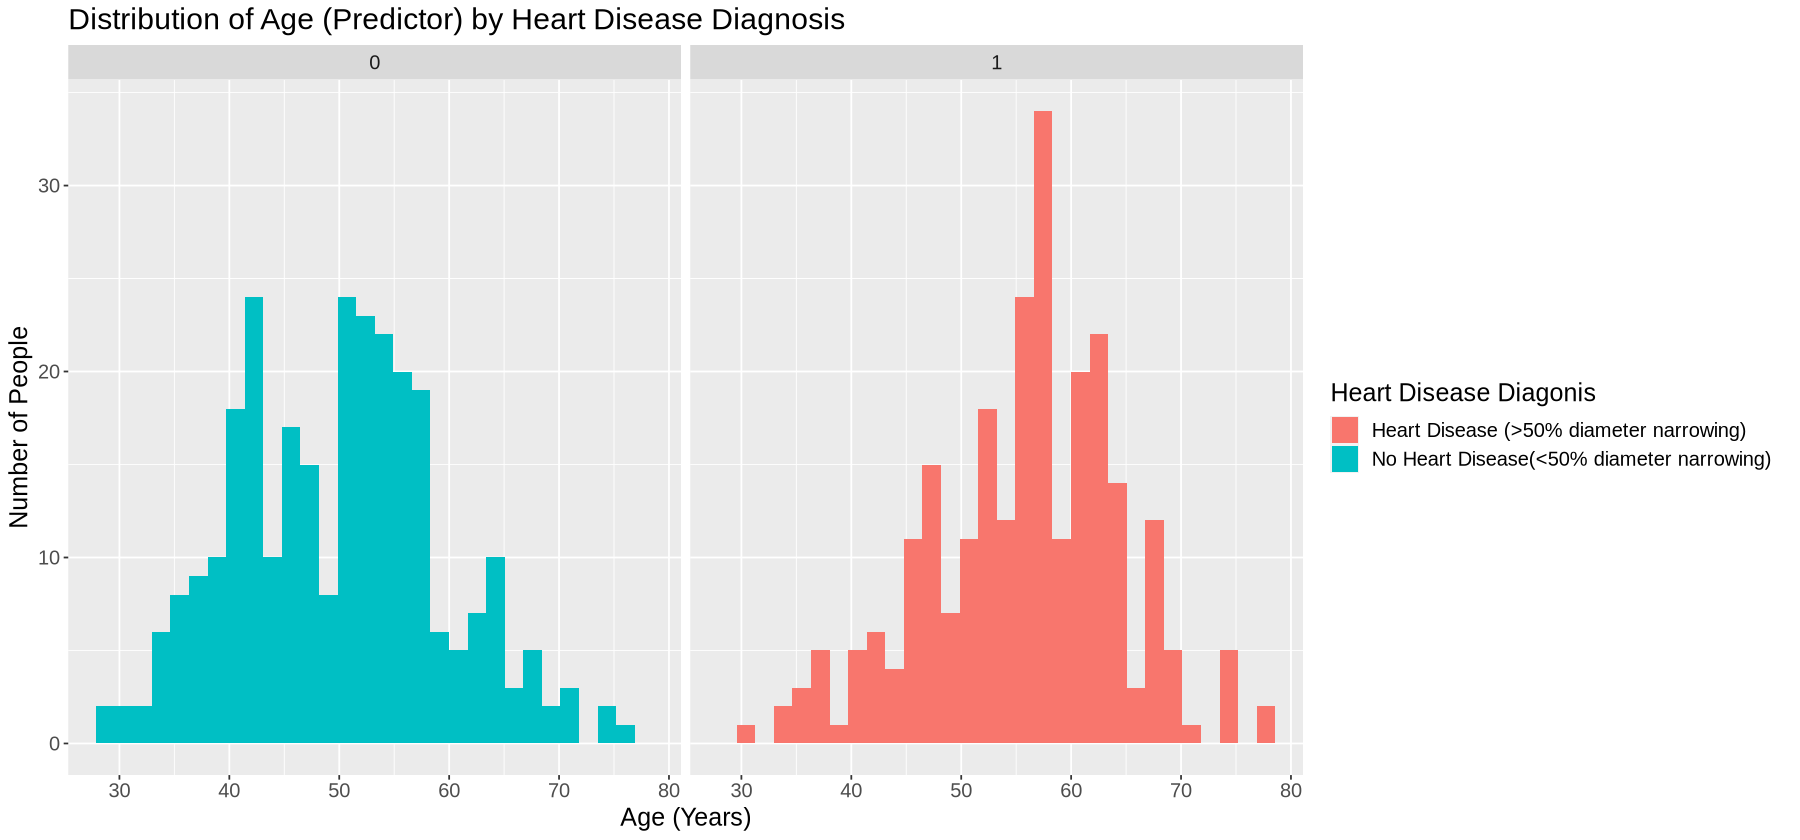

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


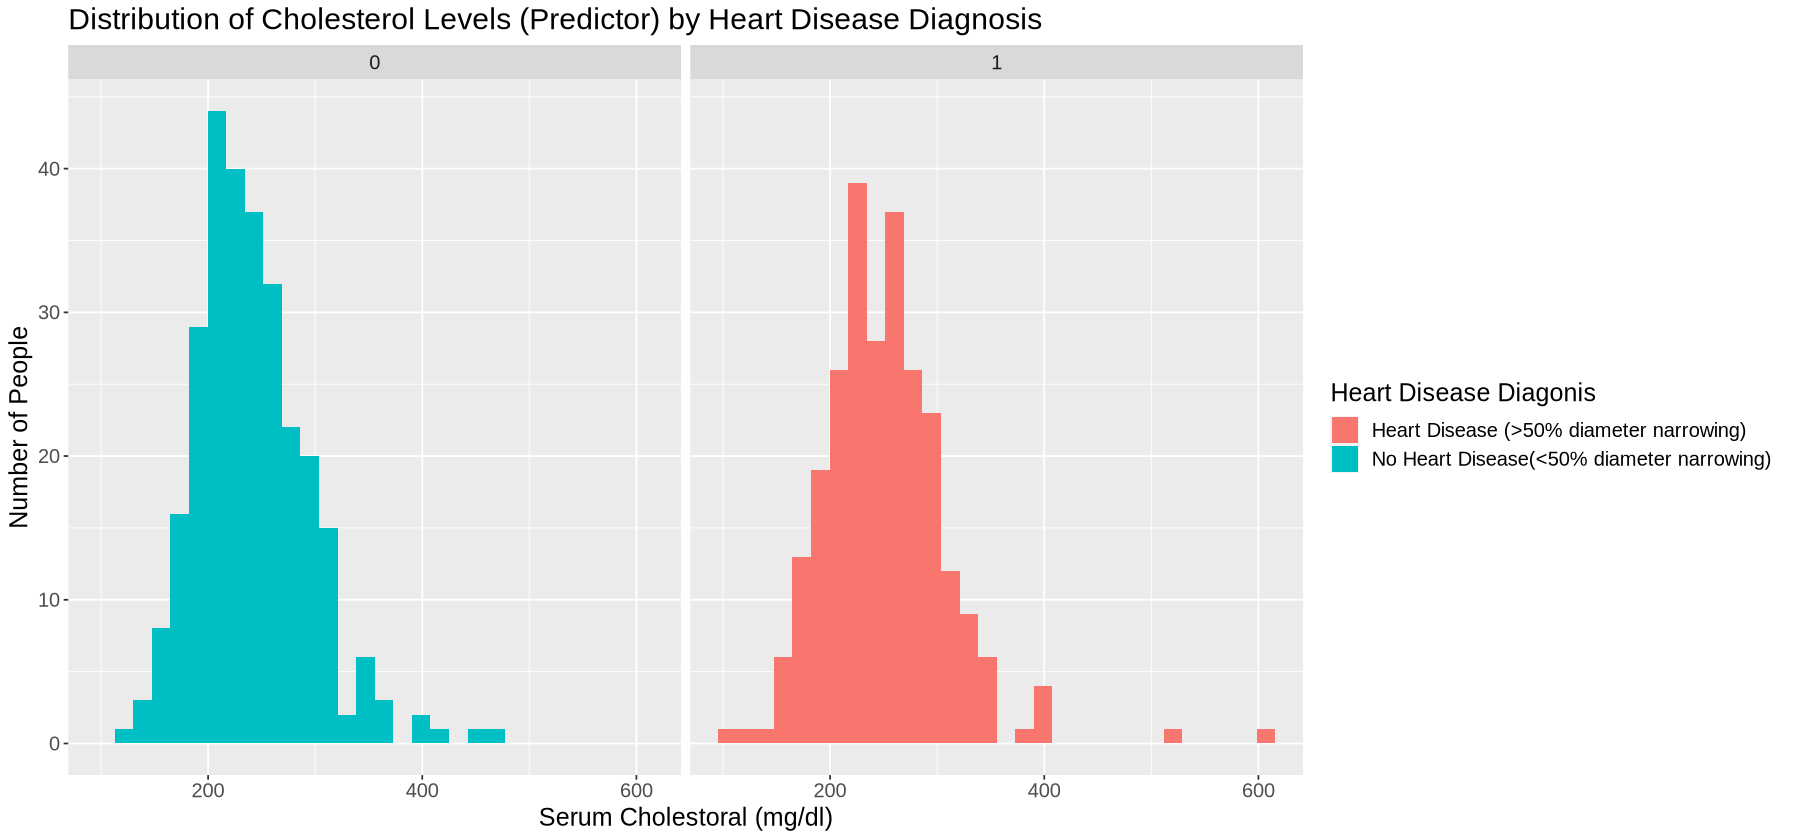

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


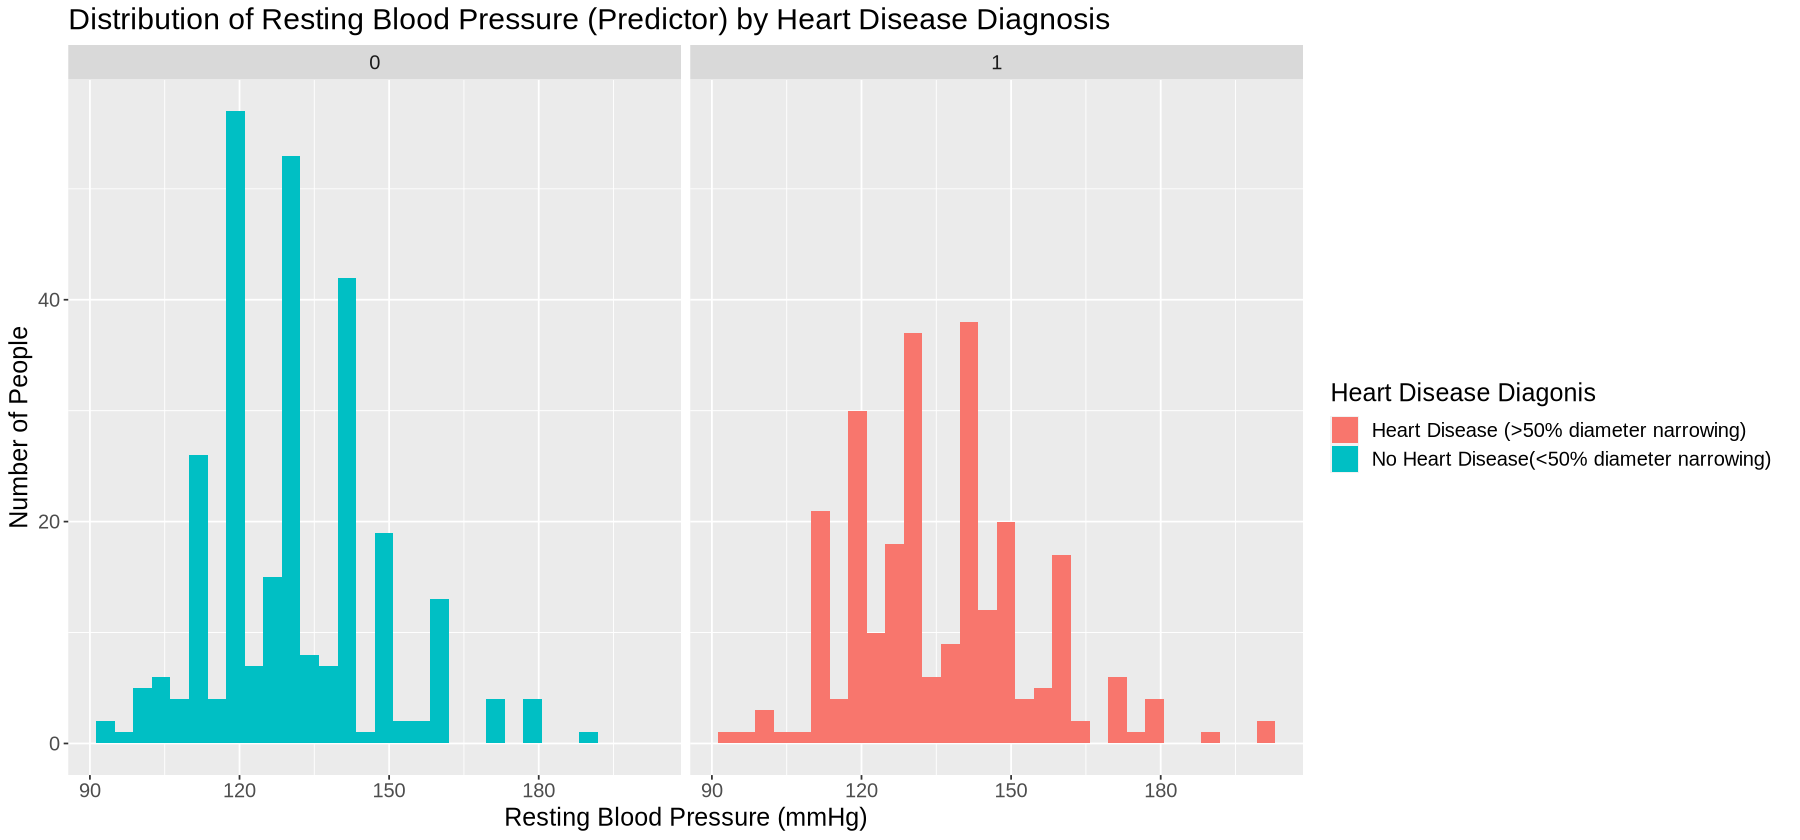

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


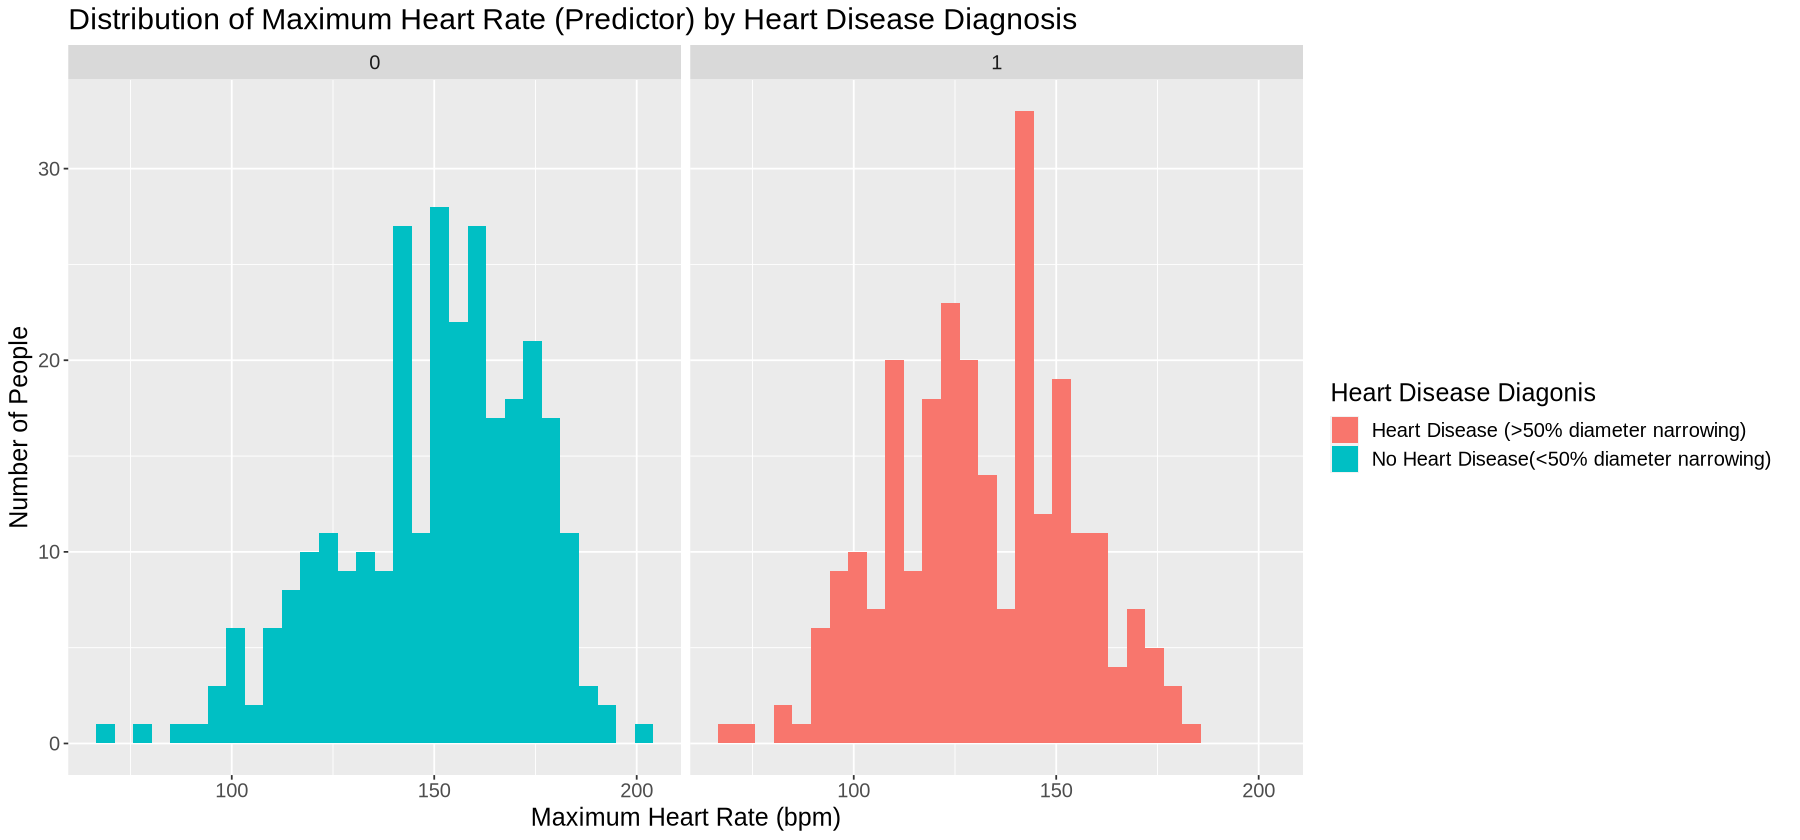

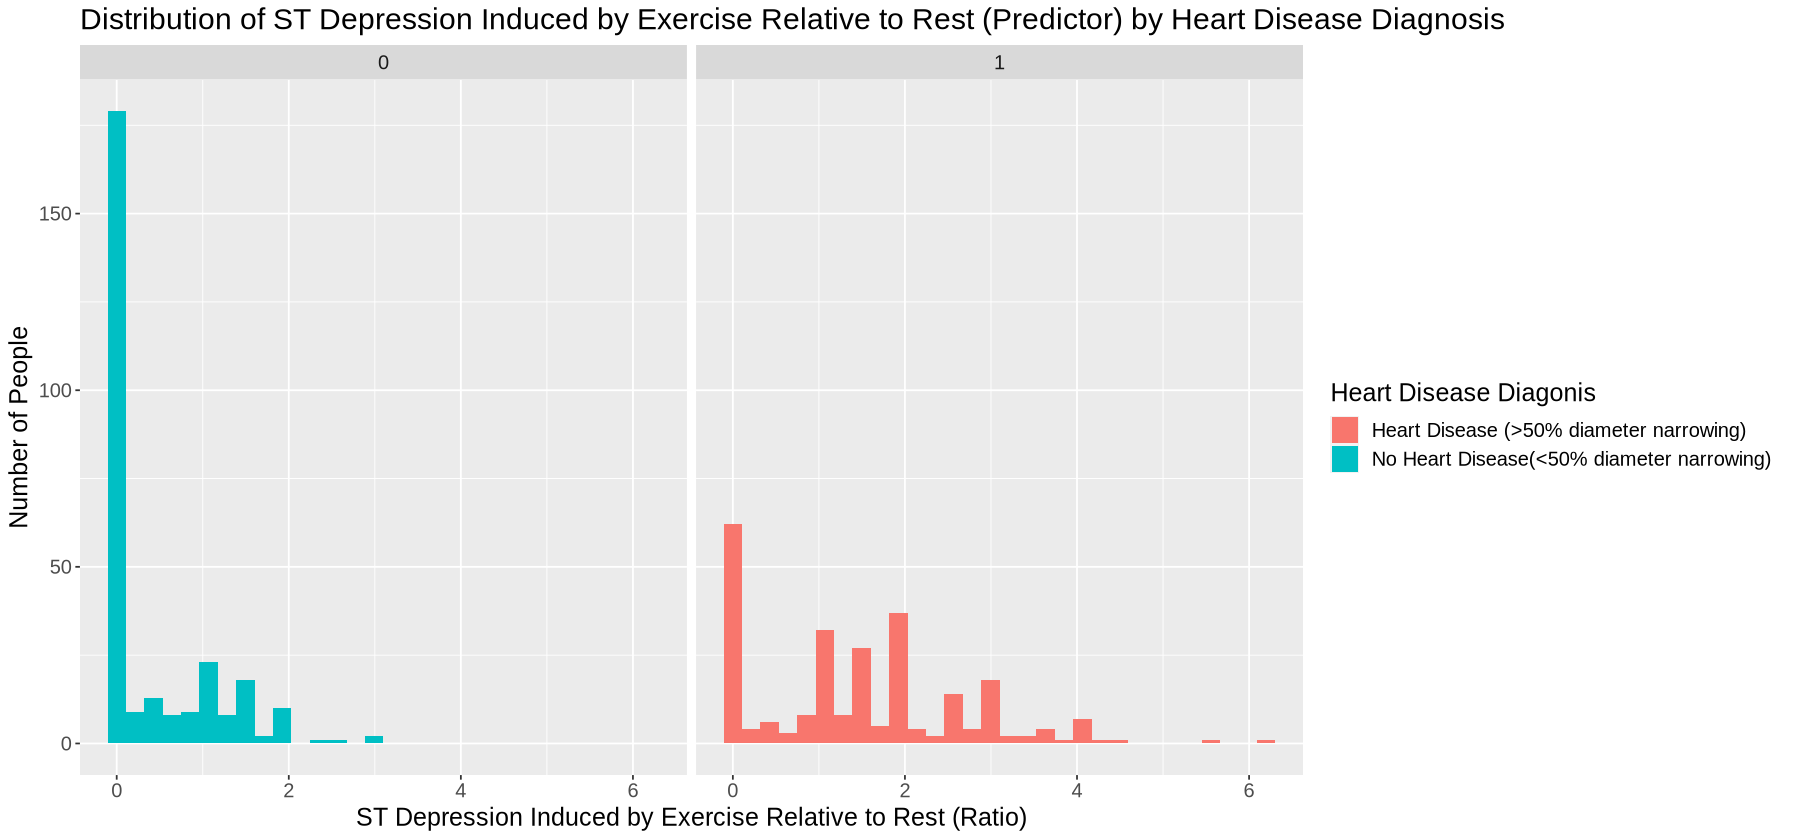

In [129]:
# Plots visualizing distribution of each variable, separated by diagnosis of heart disease

options(repr.plot.width = 15) # Alter to fit screen

# Renaming num (plots only to make the legend clearer
heart_train_renamed_num <- heart_train |>
                            mutate(diagnosis = case_when(
                                num == 0 ~ "No Heart Disease(<50% diameter narrowing)",
                                num == 1 ~ "Heart Disease (>50% diameter narrowing)"
                            ))

y_lab = "Number of People"
leg_lab = "Heart Disease Diagonis"
text_size = 15

plot_age <- ggplot(heart_train_renamed_num, aes(x = age)) +
    geom_histogram(aes(fill = diagnosis)) +
    labs(x = "Age (Years)", y = y_lab, fill = leg_lab) +
    facet_grid(cols = vars(num)) +
    ggtitle("Distribution of Age (Predictor) by Heart Disease Diagnosis") +
    theme(text = element_text(size = text_size))

plot_chol <- ggplot(heart_train_renamed_num, aes(x = chol)) +
    geom_histogram(aes(fill = diagnosis)) +
    labs(x = "Serum Cholestoral (mg/dl)", y = y_lab, fill = leg_lab) +
    facet_grid(cols = vars(num)) +
    ggtitle("Distribution of Cholesterol Levels (Predictor) by Heart Disease Diagnosis") +
    theme(text = element_text(size = text_size))

plot_trestbps <- ggplot(heart_train_renamed_num, aes(x = trestbps)) +
    geom_histogram(aes(fill = diagnosis)) +
    labs(x = "Resting Blood Pressure (mmHg)", y = y_lab, fill = leg_lab) +
    facet_grid(cols = vars(num)) +
    ggtitle("Distribution of Resting Blood Pressure (Predictor) by Heart Disease Diagnosis") +
    theme(text = element_text(size = text_size))

plot_thalach <- ggplot(heart_train_renamed_num, aes(x = thalach)) +
    geom_histogram(aes(fill = diagnosis)) +
    labs(x = "Maximum Heart Rate (bpm)", y = y_lab, fill = leg_lab) +
    facet_grid(cols = vars(num)) +
    ggtitle("Distribution of Maximum Heart Rate (Predictor) by Heart Disease Diagnosis") +
    theme(text = element_text(size = text_size))

plot_oldpeak <- ggplot(heart_train_renamed_num, aes(x = oldpeak)) +
    geom_histogram(aes(fill = diagnosis)) +
    labs(x = "ST Depression Induced by Exercise Relative to Rest (Ratio)", y = y_lab, fill = leg_lab) +
    facet_grid(cols = vars(num)) +
    theme(text = element_text(size = text_size)) +
    ggtitle("Distribution of ST Depression Induced by Exercise Relative to Rest (Predictor) by Heart Disease Diagnosis") 

plot_age
plot_chol
plot_trestbps
plot_thalach
plot_oldpeak

***
## Methods

### Choosing Predictors

* Age, cholesterol, and blood pressure are key risk factors in heart disease (Jousilahti et al., 1999). Exercised-induced ST depression and maximum heart rate have also been used in the prediction of heart disease (Bobbio et al., 1992). These relationships are reflected through the above histograms. For example, those with heart disease are distributed towards an older age, as old age increases the risk of heart disease (Jousilahti et al., 1999).
* They are Quntitive variables which means they are number. They will be better to be used for scaling and centering compared to Categorical variables. Categorical variables like sex is hard to be given a specific number to scale.
s

### KNN Classification
1. We will first standardize our data, it can reduce the bias caused by the size of our data. For example, the range for age is between **28 and 77**, but for chol, the range is between **85 and 603**! If we don't make the standardization, chol will have larger effect on the prediction
n.


In [4]:
heart_max
heart_min

ERROR: Error in eval(expr, envir, enclos): object 'heart_max' not found


2. We will use **knn_tune** to find the best number of neighbors. The best number of neighbors means it has the highest accuracy on prediction. We need to find it to make our prediction more accurate.
Then we will use classification with the best number of neighbors to make a prediction.


### Visualizing Results

1. We will use a metric table to show the accuracy of prediction about our model.
2. We will also use a confusion mat table to show the actual number about our prediction.

***
## Expected Outcomes and Significance

We expect to find a classification method that can predict heart disease based on age, serum cholesterol, resting blood pressure, maximum heart rate, and exercise-induced ST depression. The impact of such findings includes more accurate heart disease screening which can reduce the burden on the healthcare system. This could also lead to discovering certain variables that have the most significant impact on the diagnosis of heart diseases, which can give dietary and lifestyle suggestions for people with higher risks of heart disease.

***
### Citations

Janosi, A., Steinbrunn, W., Pfisterer, M., Detrano, R. *Heart Disease* UCI Machine Learning Repository [Data set]. https://doi.org/10.24432/C52P4X

Jousilahti, P., Vartiainen, E., Tuomilehto, J., Puska, P. Sex, Age, Cardiovascular Risk Factors, and Coronary Heart Disease. (1999). *Circulation, 99*, 1165-1172.  https://doi.org/10.1161/01.CIR.99.9.1165

Bobbio, M., Detrano, R., Schmid, J., Janosi, A., Righetti, A., Steinbrunn, W., Guppy, K., Abi-Mansour, P., Deckers, J., Colombo, A., Lehmann, K., Olson, H. (1992). Exercise-induced ST depression and ST/heart rate index to predict triple-vessel or left main coronary disease: A multicenter analysis. *Journal of American College of Cardiology, 19(1)*, 11-18. https://doi.org/10.1016/0735-1097(92)90044-N

(2022 8 September). Heart Disease and Stroke. CDC. https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm#:~:text=The%20Nation's%20Risk%20Factors%20and,unhealthy%20diet%2C%20and%20physical%20inactivity.